# ***Libraries***

In [1]:
!pip install modAL-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 4.8 MB/s eta 0:00:00


In [104]:
import numpy as np
import pandas as pd

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import make_scorer, f1_score


from IPython import display
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 42
np.random.seed(RANDOM_STATE_SEED)

# ***Data Overview and Exploration***

Two datasets are provided. The original dataset, in the form provided by Prof. Hofmann, contains categorical/symbolic attributes and is in the file "german.data". In this project, we utilize the original dataset and convert each categorical/symbolic value of a variable to a numerical value using label encoding, or one hot encoding in some scenarios. One hot encoding generaly is the ideal method for converting variable values when no inherent order among the categories exist.

In [187]:
gcd = pd.read_csv('German_Credit_Data.data', delimiter='\s+', header=None)

We can't rename the columns of the numerical version of the dataset.

In [ ]:
gcd = pd.read_fwf('German_Credit_Data.data-numeric', header=None)

In [5]:
gcd.head(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


Replace the column number with column names (only for the 'German_Credit_Data.data' dataset). The column names are specified in the dataset description.



In [188]:
column_names = [
    'Status of existing checking account',
    'Duration in month',
    'Credit history',
    'Purpose',
    'Credit amount',
    'Savings account/bonds',
    'Present employment since',
    'Installment rate in percentage of disposable income',
    'Personal status and sex',
    'Other debtors / guarantors',
    'Present residence since',
    'Property',
    'Age in years',
    'Other installment plans',
    'Housing',
    'Number of existing credits at this bank',
    'Job',
    'Number of people being liable to provide maintenance for',
    'Telephone',
    'foreign worker',
    'Class'
  ]

In [189]:
columns_mapping = {old_name: new_name for old_name, new_name in zip(gcd.columns, column_names)}

gcd.rename(columns=columns_mapping, inplace=True)

In [ ]:
gcd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Status of existing checking account                       1000 non-null   object
 1   Duration in month                                         1000 non-null   int64 
 2   Credit history                                            1000 non-null   object
 3   Purpose                                                   1000 non-null   object
 4   Credit amount                                             1000 non-null   int64 
 5   Savings account/bonds                                     1000 non-null   object
 6   Present employment since                                  1000 non-null   object
 7   Installment rate in percentage of disposable income       1000 non-null   int64 
 8   Personal status and sex      

In [ ]:
gcd.dropna().shape

(1000, 21)

In [ ]:
gcd.drop_duplicates().shape

(1000, 21)

There is an imbalance between the classes which we will not address in this notebook.



In [116]:
gcd['Class'].value_counts()

Class
0    700
1    300
Name: count, dtype: int64

In [190]:
gcd['Class'] = gcd['Class'].replace({1: 0, 2: 1})

In [191]:
gcd_cp = gcd.copy()

We convert the values of the categorical columns to numerical values using the label encoder.

In [192]:
categorical_columns = gcd_cp.select_dtypes(include=['object']).columns

In [193]:
label_encoder = LabelEncoder()
#gcd_cp = pd.get_dummies(gcd_cp, columns=categorical_columns)

for col in categorical_columns: gcd_cp[col] = label_encoder.fit_transform(gcd_cp[col])

In [ ]:
gcd_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype
---  ------                                                    --------------  -----
 0   Status of existing checking account                       1000 non-null   int64
 1   Duration in month                                         1000 non-null   int64
 2   Credit history                                            1000 non-null   int64
 3   Purpose                                                   1000 non-null   int64
 4   Credit amount                                             1000 non-null   int64
 5   Savings account/bonds                                     1000 non-null   int64
 6   Present employment since                                  1000 non-null   int64
 7   Installment rate in percentage of disposable income       1000 non-null   int64
 8   Personal status and sex                

In [194]:
X_gcd = gcd_cp.drop(columns=['Class'])
Y_gcd = gcd_cp['Class']

In [66]:
X_gcd.isnull().values.any()

False

In [195]:
X_gcd = X_gcd.to_numpy()
Y_gcd = Y_gcd.to_numpy()

In [ ]:
print(X_gcd[0])

In [ ]:
# If one hot encoder is used, use the below code.
for entry in X_gcd:
  for value in range(7, len(entry)):
    if entry[value]:
      entry[value] = 0
    else:
      entry[value] = 1

In [ ]:
print(X_gcd[0])





For visualization purposes, we apply PCA to the original dataset.

In [121]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_gcd = pca.fit_transform(X=X_gcd)

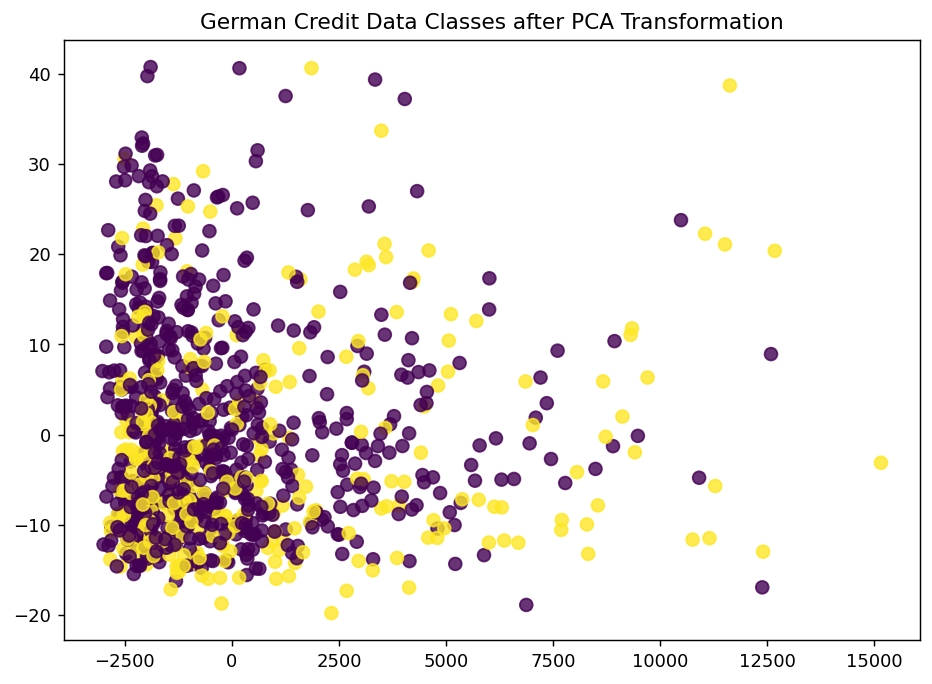

In [122]:
# Isolate the data we'll need for plotting.
x_component, y_component = transformed_gcd[:, 0], transformed_gcd[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=Y_gcd, cmap='viridis', s=50, alpha=8/10)
plt.title('German Credit Data Classes after PCA Transformation')
plt.show()

It becomes obvious from the plot that the points belonging to each class are intermixed. This can happen for two reasons:
- The data samples, in their original form with all columns included (prior to dimensionality reduction), are sufficiently similar that when the dimensions are reduced, the points become intermixed.
- Reducing the initial dimensions causes the points to appear intermixed.

The intermixed points may result in minimal or no performance improvement from the classification process when using uncertainty and random sampling methods. This phenomenon can be attributed to the lack of clear boundaries between classes. When points (in 2D), or data samples in their original form, from different classes are closely intermixed (very similar to one another), it becomes challenging for the classifier to discern and learn the underlying patterns effectively. As a result, the classifier's ability to make accurate predictions is hampered because it cannot easily separate the classes based on the available features. This ambiguity undermines the benefits of advanced sampling strategies like uncertainty sampling, which relies on identifying the most informative points to query. Consequently, the classifier's performance remains stagnant or only slightly improves, as it struggles to gain significant insights from the ambiguously placed points in the dataset.

# ***Active Learning***
**Note**: Class 1 = Good Customer, Class 2 = Bad Customer

The rows represent the actual classification and the columns the predicted classification.

It is worse to categorize a customer as "Good" when they are "Bad" (5), than it is to class a customer as "Bad" when they are "Good" (1).

In [196]:
ORIGINAL_COST = [
    [0,1],
    [5,0]
]

In [ ]:
"""
                          Predicted Good Customer (1)   Predicted Bad Customer (2)
Actual Good Customer (1)           TN                      FP
Actual Bad  Customer (2)           FN                      TP
"""

Class 1 -> 0 |
Class 2 -> 1

In [197]:
class_weights = {0: 1, 1: 5}

We define a custom scorer based on the cost matrix

In [198]:
def cost_sensitive_score(y_true, y_pred):
    total_cost = 0
    for i in range(len(y_true)):
        total_cost += ORIGINAL_COST[y_true[i]][y_pred[i]]
    return total_cost

cost_sensitive_scorer = make_scorer(cost_sensitive_score, cost_matrix=ORIGINAL_COST, greater_is_better=False)

In [199]:
def compute_cost_sensitive_score(learner, X, y):
    predictions = learner.predict(X)
    is_correct = (predictions == y)
    return cost_sensitive_score(y, predictions), is_correct, f1_score(y, predictions, average='weighted')

We split the dataset according to the class imbalance

In [200]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_gcd.shape[0]


sss = StratifiedShuffleSplit(n_splits=1, train_size=100, random_state=RANDOM_STATE_SEED)

for train_index, pool_index in sss.split(X_gcd, Y_gcd):
    X_train = X_gcd[train_index]
    y_train = Y_gcd[train_index]
    X_pool = X_gcd[pool_index]
    y_pool = Y_gcd[pool_index]

train_indices = np.array([np.where((X_gcd == x).all(axis=1))[0][0] for x in X_train])

In [ ]:
# Uncomment if there is no class imbalance
"""
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=10) # size number of training examples are used

X_train = X_gcd[training_indices]
y_train = Y_gcd[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_gcd, training_indices, axis=0)
y_pool = np.delete(Y_gcd, training_indices, axis=0)
"""

The training and pooling set are stratified.

In [201]:
# For numpy arrays
train_counts = np.bincount(y_train)
pool_counts = np.bincount(y_pool)

print("Train Counts:")
for value, count in enumerate(train_counts):
    if count > 0:
        print(f"Value {value}: Frequency {count}")

print("\nPool Counts:")
for value, count in enumerate(pool_counts):
    if count > 0:
        print(f"Value {value}: Frequency {count}")


Train Counts:
Value 0: Frequency 70
Value 1: Frequency 30

Pool Counts:
Value 0: Frequency 630
Value 1: Frequency 270


In [23]:
# Optional (Do not execute)
X_gcd = np.delete(X_gcd, train_indices, axis=0)
Y_gcd = np.delete(Y_gcd, train_indices, axis=0)

## **KNN**

KNN for a pre-defined k

In [38]:
# Specify our core estimator along with it's active learning model.
model = KNeighborsClassifier(n_neighbors=5)
learner = ActiveLearner(estimator=model, query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)

In [39]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_gcd)
is_correct = (predictions == Y_gcd)

In [ ]:
# Record our learner's score on the raw data.
#unqueried_score = learner.score(X_gcd, Y_gcd)
#print(unqueried_score)

unqueried_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_gcd, Y_gcd)
print(f'Unqueried score: {unqueried_score} Correct: {sum(is_correct)} Incorrect: {X_gcd.shape[0] - sum(is_correct)} F1: {f1}')

KNN for the optimal k

In [206]:
knn_clfs = {}
for k in range(1, 10):
  model = KNeighborsClassifier(n_neighbors=k)
  learner = ActiveLearner(estimator=model, query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)

  #predictions = learner.predict(X_gcd)
  #is_correct = (predictions == Y_gcd)

  unqueried_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_gcd, Y_gcd)
  print(f'K: {k} Unqueried score: {unqueried_score} Correct: {sum(is_correct)} Incorrect: {X_gcd.shape[0] - sum(is_correct)} F1: {f1}')
  knn_clfs[k] = [unqueried_score, is_correct]

K: 1 Unqueried score: 1143 Correct: 613 Incorrect: 387 F1: 0.6146076289163623
K: 2 Unqueried score: 1405 Correct: 675 Incorrect: 325 F1: 0.6058863736882313
K: 3 Unqueried score: 1341 Correct: 611 Incorrect: 389 F1: 0.5893942432858653
K: 4 Unqueried score: 1436 Correct: 652 Incorrect: 348 F1: 0.5889525794684731
K: 5 Unqueried score: 1373 Correct: 627 Incorrect: 373 F1: 0.5924360800862833
K: 6 Unqueried score: 1443 Correct: 669 Incorrect: 331 F1: 0.5926153846153847
K: 7 Unqueried score: 1365 Correct: 603 Incorrect: 397 F1: 0.5809499089575542
K: 8 Unqueried score: 1363 Correct: 641 Incorrect: 359 F1: 0.6014680543599882
K: 9 Unqueried score: 1385 Correct: 575 Incorrect: 425 F1: 0.5615876919196696


Unqueried Plotting

In [209]:
# Choose the k that exhibits the highest accuracy
model = KNeighborsClassifier(n_neighbors=2)
learner = ActiveLearner(estimator=model, query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)

unqueried_score = knn_clfs[2][0]
is_correct = knn_clfs[2][1]

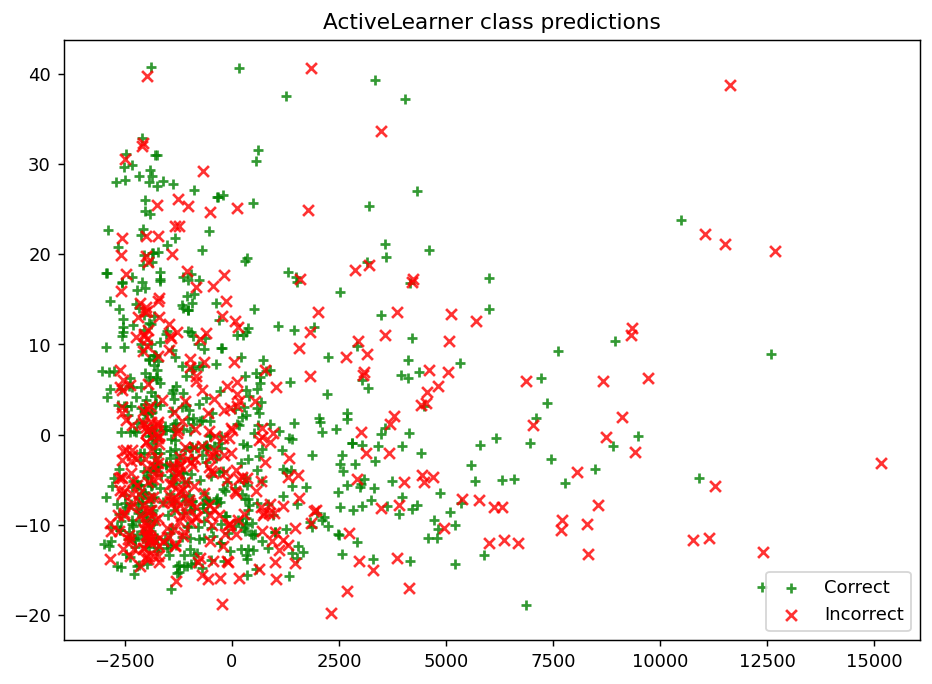

In [204]:
# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions")
plt.show()

### Uncertainty Sampling


In [208]:
N_QUERIES = 30
performance_history = [f1]

# Allow our model to query our unlabeled dataset for the most informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X = X_pool[query_index].reshape(1, -1)
  y = y_pool[query_index].reshape(1, )

  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  #model_accuracy = learner.score(X_gcd, Y_gcd)
  #print('Raw accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  model_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_gcd, Y_gcd)
  print(f'Q: {index} Model score: {model_score} Correct: {sum(is_correct)} Incorrect: {X_gcd.shape[0] - sum(is_correct)} F1: {f1}')

  # Save our model's performance for plotting.
  performance_history.append(f1)

Q: 0 Model score: 1405 Correct: 675 Incorrect: 325 F1: 0.6058863736882313
Q: 1 Model score: 1405 Correct: 675 Incorrect: 325 F1: 0.6058863736882313
Q: 2 Model score: 1393 Correct: 675 Incorrect: 325 F1: 0.6092472171401594
Q: 3 Model score: 1393 Correct: 675 Incorrect: 325 F1: 0.6092472171401594
Q: 4 Model score: 1393 Correct: 675 Incorrect: 325 F1: 0.6092472171401594
Q: 5 Model score: 1393 Correct: 675 Incorrect: 325 F1: 0.6092472171401594
Q: 6 Model score: 1393 Correct: 675 Incorrect: 325 F1: 0.6092472171401594
Q: 7 Model score: 1393 Correct: 675 Incorrect: 325 F1: 0.6092472171401594
Q: 8 Model score: 1393 Correct: 675 Incorrect: 325 F1: 0.6092472171401594
Q: 9 Model score: 1393 Correct: 675 Incorrect: 325 F1: 0.6092472171401594
Q: 10 Model score: 1393 Correct: 675 Incorrect: 325 F1: 0.6092472171401594
Q: 11 Model score: 1378 Correct: 678 Incorrect: 322 F1: 0.6144736426218939
Q: 12 Model score: 1378 Correct: 678 Incorrect: 322 F1: 0.6144736426218939
Q: 13 Model score: 1378 Correct: 67

With uncertainty sampling we see a slight reduction of the cost and the incorrect predictions, and an increase of the F1 and the number of correct predictions.  

### Random Sampling
We perform random sampling by essentialy picking a random sample from the pooling set.

In [210]:
N_QUERIES = 30
performance_history = [f1]

# Allow our model to query our unlabeled dataset for the most informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index = np.random.choice(X_pool.shape[0])

  # Teach our ActiveLearner model the record it has requested.
  X = X_pool[query_index].reshape(1, -1)
  y = y_pool[query_index].reshape(1, )

  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  #model_accuracy = learner.score(X_gcd, Y_gcd)
  #print('Raw accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  model_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_gcd, Y_gcd)
  print(f'Q: {index} Model score: {model_score} Correct: {sum(is_correct)} Incorrect: {X_gcd.shape[0] - sum(is_correct)} F1: {f1}')

  # Save our model's performance for plotting.
  performance_history.append(f1)

Q: 0 Model score: 1405 Correct: 675 Incorrect: 325 F1: 0.6058863736882313
Q: 1 Model score: 1405 Correct: 675 Incorrect: 325 F1: 0.6058863736882313
Q: 2 Model score: 1391 Correct: 669 Incorrect: 331 F1: 0.6074660128914736
Q: 3 Model score: 1391 Correct: 669 Incorrect: 331 F1: 0.6074660128914736
Q: 4 Model score: 1391 Correct: 669 Incorrect: 331 F1: 0.6074660128914736
Q: 5 Model score: 1391 Correct: 669 Incorrect: 331 F1: 0.6074660128914736
Q: 6 Model score: 1391 Correct: 669 Incorrect: 331 F1: 0.6074660128914736
Q: 7 Model score: 1391 Correct: 669 Incorrect: 331 F1: 0.6074660128914736
Q: 8 Model score: 1398 Correct: 662 Incorrect: 338 F1: 0.6028524977830328
Q: 9 Model score: 1398 Correct: 662 Incorrect: 338 F1: 0.6028524977830328
Q: 10 Model score: 1423 Correct: 665 Incorrect: 335 F1: 0.597224054590626
Q: 11 Model score: 1423 Correct: 665 Incorrect: 335 F1: 0.597224054590626
Q: 12 Model score: 1423 Correct: 665 Incorrect: 335 F1: 0.597224054590626
Q: 13 Model score: 1423 Correct: 665 I

Using random sampling, we observe a reduction in cost for some queries, but a cost increase in most queries. Overall, the F1-score is slightly worse. Although the number of correct and incorrect predictions in queries 25-27 is the same as with uncertainty sampling, the cost is higher and the F1-score is lower.

### Performance and Graph Plots

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification performance')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification F1')

plt.show()

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_gcd)
is_correct = (predictions == Y_gcd)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification performance after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

## **Random Forests**

Random Forests for the default parameters

In [215]:
# Specify our core estimator along with it's active learning model.
model = RandomForestClassifier(random_state=RANDOM_STATE_SEED, class_weight=class_weights)
learner = ActiveLearner(estimator=model, query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_gcd)
is_correct = (predictions == Y_gcd)

In [216]:
# Record our learner's score on the raw data.
unqueried_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_gcd, Y_gcd)
print(f'Unqueried score: {unqueried_score} Correct: {sum(is_correct)} Incorrect: {X_gcd.shape[0] - sum(is_correct)} F1: {f1}')

Unqueried score: 1152 Correct: 740 Incorrect: 260 F1: 0.696840104537895


Hyper parameter tuning for Random Forests

In [139]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight=class_weights), param_grid=param_grid, n_jobs=-1, verbose=3, scoring=cost_sensitive_scorer)

In [ ]:
grid_search.fit(X_train, y_train)

In [142]:
# Get the best parameters from the random search
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 50}


In [143]:
# Specify our core estimator along with it's active learning model.
model = RandomForestClassifier(bootstrap=True, max_depth=10, n_estimators=50, random_state=RANDOM_STATE_SEED, class_weight=class_weights)
learner = ActiveLearner(estimator=model, query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_gcd)
is_correct = (predictions == Y_gcd)

In [ ]:
# Record our learner's score on the raw data.
#unqueried_score = learner.score(X_gcd, Y_gcd)

unqueried_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_gcd, Y_gcd)
print(f'Unqueried score: {unqueried_score} Correct: {sum(is_correct)} Incorrect: {X_gcd.shape[0] - sum(is_correct)} F1: {f1}')

#### Unqueried Plotting

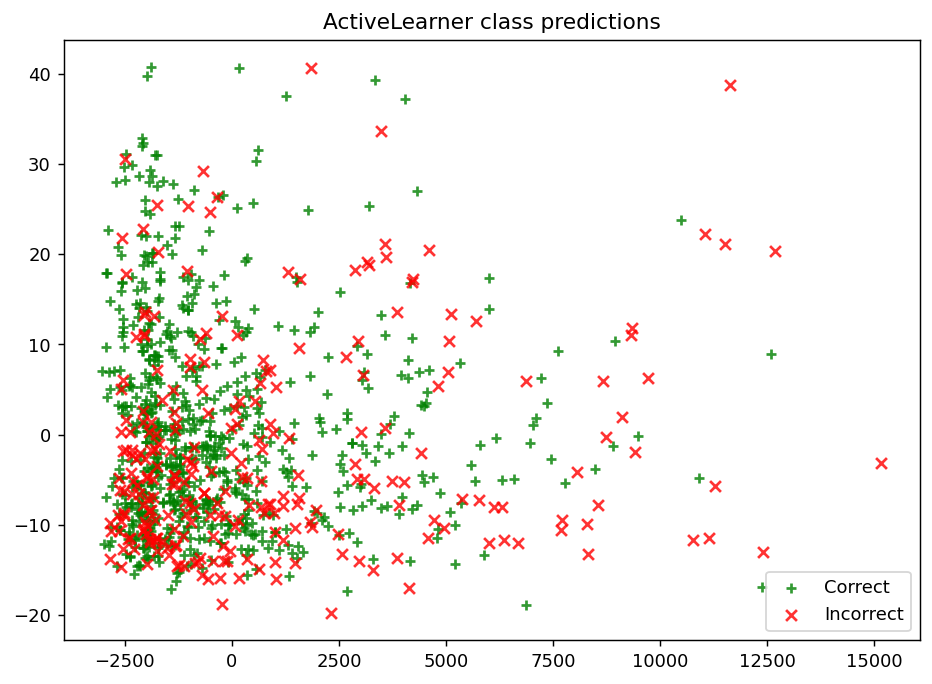

In [213]:
# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions")
plt.show()

### Uncertainty Sampling


In [214]:
N_QUERIES = 30
performance_history = [f1]

# Allow our model to query our unlabeled dataset for the most informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X = X_pool[query_index].reshape(1, -1)
  y = y_pool[query_index].reshape(1, )

  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  #model_accuracy = learner.score(X_gcd, Y_gcd)
  #print('Raw accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  model_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_gcd, Y_gcd)
  print(f'Q: {index} Model score: {model_score} Correct: {sum(is_correct)} Incorrect: {X_gcd.shape[0] - sum(is_correct)} F1: {f1}')

  # Save our model's performance for plotting.
  performance_history.append(f1)

Q: 0 Model score: 1170 Correct: 734 Incorrect: 266 F1: 0.6898441069503081
Q: 1 Model score: 1197 Correct: 735 Incorrect: 265 F1: 0.6848867953769496
Q: 2 Model score: 1126 Correct: 746 Incorrect: 254 F1: 0.7053139687513232
Q: 3 Model score: 1119 Correct: 745 Incorrect: 255 F1: 0.7059593356629204
Q: 4 Model score: 1101 Correct: 743 Incorrect: 257 F1: 0.7078065440123389
Q: 5 Model score: 1114 Correct: 746 Incorrect: 254 F1: 0.7074657599846758
Q: 6 Model score: 1107 Correct: 745 Incorrect: 255 F1: 0.7080564247973541
Q: 7 Model score: 1088 Correct: 748 Incorrect: 252 F1: 0.7131627734519836
Q: 8 Model score: 1105 Correct: 751 Incorrect: 249 F1: 0.7121790002090984
Q: 9 Model score: 1121 Correct: 747 Incorrect: 253 F1: 0.7068367049645325
Q: 10 Model score: 1134 Correct: 750 Incorrect: 250 F1: 0.7062518474726573
Q: 11 Model score: 1151 Correct: 749 Incorrect: 251 F1: 0.7023382756367369
Q: 12 Model score: 1154 Correct: 750 Incorrect: 250 F1: 0.7023193370096423
Q: 13 Model score: 1141 Correct: 74

We achieve the best results in query 29 with the lowest cost, number of incorrect predictions, highest number of correct predictions and F1-score.

### Random Sampling
We perform random sampling by essentialy picking a random sample from the pooling set.

In [217]:
N_QUERIES = 30
performance_history = [f1]

# Allow our model to query our unlabeled dataset for the most informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index = np.random.choice(X_pool.shape[0])

  # Teach our ActiveLearner model the record it has requested.
  X = X_pool[query_index].reshape(1, -1)
  y = y_pool[query_index].reshape(1, )

  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  #model_accuracy = learner.score(X_gcd, Y_gcd)
  #print('Raw accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  model_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_gcd, Y_gcd)
  print(f'Q: {index} Model score: {model_score} Correct: {sum(is_correct)} Incorrect: {X_gcd.shape[0] - sum(is_correct)} F1: {f1}')

  # Save our model's performance for plotting.
  performance_history.append(f1)

Q: 0 Model score: 1144 Correct: 740 Incorrect: 260 F1: 0.6983528813989924
Q: 1 Model score: 1146 Correct: 742 Incorrect: 258 F1: 0.6991721037337573
Q: 2 Model score: 1130 Correct: 750 Incorrect: 250 F1: 0.7070102776499464
Q: 3 Model score: 1146 Correct: 746 Incorrect: 254 F1: 0.70155187703222
Q: 4 Model score: 1138 Correct: 746 Incorrect: 254 F1: 0.7030838081729476
Q: 5 Model score: 1108 Correct: 748 Incorrect: 252 F1: 0.7097691791973948
Q: 6 Model score: 1102 Correct: 746 Incorrect: 254 F1: 0.7095422900311065
Q: 7 Model score: 1104 Correct: 748 Incorrect: 252 F1: 0.7104640549778979
Q: 8 Model score: 1095 Correct: 745 Incorrect: 255 F1: 0.7100804230472624
Q: 9 Model score: 1101 Correct: 747 Incorrect: 253 F1: 0.7103461783283553
Q: 10 Model score: 1060 Correct: 752 Incorrect: 248 F1: 0.7202493044220749
Q: 11 Model score: 1081 Correct: 747 Incorrect: 253 F1: 0.7136541467052105
Q: 12 Model score: 1053 Correct: 755 Incorrect: 245 F1: 0.7233269189651486
Q: 13 Model score: 1022 Correct: 762 

Using random sampling we achieve even better results in query 23 in terms of the total cost (1001) and F1-score. The number of correct and incorrect predictions are essentialy the same with uncertainty sampling. In an ideal scenario we would expect random sampling to perform worse than uncertainty sampling but in this case, as we described earlier, the results are not surprising.

### Performance and Graph Plots

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification performance')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification F1')

plt.show()

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_gcd)
is_correct = (predictions == Y_gcd)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification performance after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

## **Logistic Regression**

Logistic regression for the default parameters

In [222]:
# Specify our core estimator along with it's active learning model.
model = LogisticRegression(random_state=RANDOM_STATE_SEED, max_iter=10000, class_weight=class_weights)
learner = ActiveLearner(estimator=model, query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_gcd)
is_correct = (predictions == Y_gcd)

In [223]:
# Record our learner's score on the raw data.
#unqueried_score = learner.score(X_gcd, Y_gcd)
#print(unqueried_score)

unqueried_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_gcd, Y_gcd)
print(f'Unqueried score: {unqueried_score} Correct: {sum(is_correct)} Incorrect: {X_gcd.shape[0] - sum(is_correct)} F1: {f1}')

Unqueried score: 619 Correct: 633 Incorrect: 367 F1: 0.6474278227879009


Plotting and Evaluation through Querying

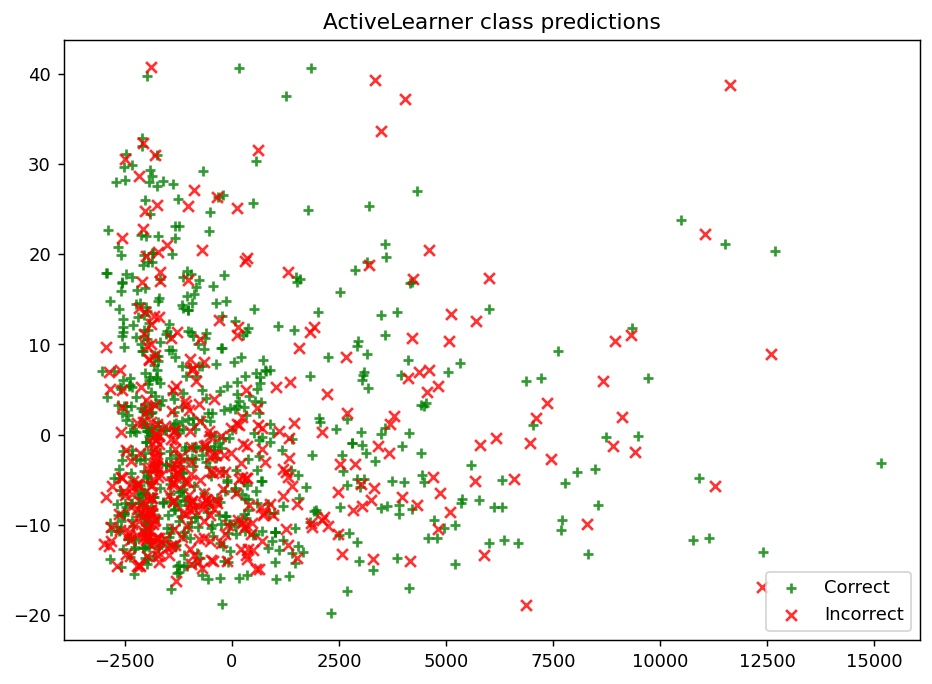

In [220]:
# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions")
plt.show()

### Uncertainty Sampling


In [221]:
N_QUERIES = 30
performance_history = [f1]

# Allow our model to query our unlabeled dataset for the most informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X = X_pool[query_index].reshape(1, -1)
  y = y_pool[query_index].reshape(1, )

  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  #model_accuracy = learner.score(X_gcd, Y_gcd)
  #print('Raw accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  model_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_gcd, Y_gcd)
  print(f'Q: {index} Model score: {model_score} Correct: {sum(is_correct)} Incorrect: {X_gcd.shape[0] - sum(is_correct)} F1: {f1}')

  # Save our model's performance for plotting.
  performance_history.append(f1)

Q: 0 Model score: 623 Correct: 629 Incorrect: 371 F1: 0.6434355388201543
Q: 1 Model score: 623 Correct: 637 Incorrect: 363 F1: 0.6515299178797483
Q: 2 Model score: 639 Correct: 633 Incorrect: 367 F1: 0.6477485462288419
Q: 3 Model score: 629 Correct: 631 Incorrect: 369 F1: 0.6455765908103963
Q: 4 Model score: 619 Correct: 641 Incorrect: 359 F1: 0.6554815355819519
Q: 5 Model score: 602 Correct: 630 Incorrect: 370 F1: 0.6440199288023509
Q: 6 Model score: 598 Correct: 630 Incorrect: 370 F1: 0.643928501405137
Q: 7 Model score: 605 Correct: 627 Incorrect: 373 F1: 0.640994292282893
Q: 8 Model score: 602 Correct: 634 Incorrect: 366 F1: 0.6481230345911949
Q: 9 Model score: 610 Correct: 630 Incorrect: 370 F1: 0.6441943734015344
Q: 10 Model score: 602 Correct: 630 Incorrect: 370 F1: 0.6440199288023509
Q: 11 Model score: 606 Correct: 634 Incorrect: 366 F1: 0.6482023673439287
Q: 12 Model score: 586 Correct: 630 Incorrect: 370 F1: 0.6436374312405451
Q: 13 Model score: 616 Correct: 628 Incorrect: 372

### Random Sampling
We perform random sampling by essentialy picking a random sample from the pooling set.

In [224]:
N_QUERIES = 30
performance_history = [f1]

# Allow our model to query our unlabeled dataset for the most informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index = np.random.choice(X_pool.shape[0])

  # Teach our ActiveLearner model the record it has requested.
  X = X_pool[query_index].reshape(1, -1)
  y = y_pool[query_index].reshape(1, )

  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  #model_accuracy = learner.score(X_gcd, Y_gcd)
  #print('Raw accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  model_score, is_correct, f1 = compute_cost_sensitive_score(learner, X_gcd, Y_gcd)
  print(f'Q: {index} Model score: {model_score} Correct: {sum(is_correct)} Incorrect: {X_gcd.shape[0] - sum(is_correct)} F1: {f1}')

  # Save our model's performance for plotting.
  performance_history.append(f1)

Q: 0 Model score: 628 Correct: 628 Incorrect: 372 F1: 0.6425129962774071
Q: 1 Model score: 611 Correct: 633 Incorrect: 367 F1: 0.6472798995875919
Q: 2 Model score: 628 Correct: 628 Incorrect: 372 F1: 0.6425129962774071
Q: 3 Model score: 603 Correct: 637 Incorrect: 363 F1: 0.6511987992015182
Q: 4 Model score: 629 Correct: 615 Incorrect: 385 F1: 0.6291372775625719
Q: 5 Model score: 611 Correct: 625 Incorrect: 375 F1: 0.6390693287026403
Q: 6 Model score: 612 Correct: 628 Incorrect: 372 F1: 0.6421848162143593
Q: 7 Model score: 581 Correct: 635 Incorrect: 365 F1: 0.6486941466039032
Q: 8 Model score: 624 Correct: 612 Incorrect: 388 F1: 0.6258529142508391
Q: 9 Model score: 625 Correct: 607 Incorrect: 393 F1: 0.6205955906915729
Q: 10 Model score: 633 Correct: 611 Incorrect: 389 F1: 0.6250625311128553
Q: 11 Model score: 631 Correct: 621 Incorrect: 379 F1: 0.6354067034549582
Q: 12 Model score: 625 Correct: 615 Incorrect: 385 F1: 0.6290290545186015
Q: 13 Model score: 625 Correct: 619 Incorrect: 3

### Performance and Graph Plots

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification performance')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification F1')

plt.show()

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_gcd)
is_correct = (predictions == Y_gcd)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification performance after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()